In [ ]:
# Final Project 

In [2]:
# Imports

from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [3]:
# Files

df_athlete_events = pd.read_csv('data/Athlete_Info/athlete_events.csv')
print(len(df_athlete_events))
df_athlete_events.head()

271116


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [4]:
df_noc_regions = pd.read_csv('data/Athlete_Info/noc_regions.csv')
print(len(df_noc_regions))
df_noc_regions.head()

230


,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [5]:
df_world_pop = pd.read_csv('data/WorldPopulation.csv')
print(len(df_world_pop))

# drop unwanted columns 
df_world_pop = df_world_pop.drop(["Indicator Name","Indicator Code","Unnamed: 61"],axis=1)

# Pivot population table
df_world_pop = df_world_pop.melt(id_vars=["Country", "Country Code"], 
        var_name="Year", 
        value_name="Value")

df_world_pop['Year']=df_world_pop['Year'].astype(int)

df_world_pop.head()

217


,Country,Country Code,Year,Value
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [6]:
# merge
df_olympics = df_athlete_events.merge(df_world_pop, left_on = ["NOC","Year"], right_on = ["Country Code","Year"], how = 'left')
df_olympics['Population'] = df_olympics['Value'].apply(lambda x: '%.5f' % x)

df_olympics.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Country Code,Value,Population
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,CHN,1.164970e+09,1164970000.00000
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,CHN,1.350695e+09,1350695000.00000
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,NaN,NaN,NaN,nan
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,NaN,NaN,NaN,nan
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,NaN,NaN,NaN,nan


In [6]:
# ???
# df_gdp = pd.read_csv('data/w_gdp.csv')
# print(len(df_gdp))

# # drop unwanted columns 
# df_world_pop = df_world_pop.drop(["Indicator Name","Indicator Code","Unnamed: 61"],axis=1)

# # Pivot population table
# df_world_pop = df_world_pop.melt(id_vars=["Country", "Country Code"], 
#         var_name="Year", 
#         value_name="Value")

# df_world_pop['Year']=df_world_pop['Year'].astype(int)

# df_world_pop.head()

In [7]:
# merge
df_olympics = df_olympics.merge(df_noc_regions, left_on = 'NOC', right_on = 'NOC', how = 'left')
df_olympics.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,City,Sport,Event,Medal,Country,Country Code,Value,Population,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,CHN,1.164970e+09,1164970000.00000,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,London,Judo,Judo Men's Extra-Lightweight,NaN,China,CHN,1.350695e+09,1350695000.00000,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,Antwerpen,Football,Football Men's Football,NaN,NaN,NaN,NaN,nan,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,NaN,NaN,NaN,nan,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,NaN,NaN,NaN,nan,Netherlands,NaN


They forecast medal totals based on only four factors: A country’s population, its comparative level of wealth, its performance in previous Olympic Games, and whether it is hosting that year’s Olympic Games.

In [8]:
# clean the data
## Columns w/ NaNs: Age, Weight, Height, Medal
df_olympics['Medal'].fillna('DNW', inplace = True)

df_olympics = df_olympics.drop(['notes','region'], 1)

In [9]:
# France has 160 teams...
print(df_olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head())

FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: NOC, dtype: int64


In [10]:
# ??? 
# update some incorrect country names
#1. SGP - Singapore
#2. ROT - Refugee Olympic Athletes
#3. UNK - Unknown
#4. TUV - Tuvalu

In [10]:
# Count medals Won
df_olympics['Medal_Won'] = np.where(df_olympics.loc[:,'Medal'] == 'DNW', 0, 1)

In [11]:
# identify list of team events, we define this as events where Gold wins per team/year/event are > 1

identify_team_events = pd.pivot_table(df_olympics,
                                      index = ['Team', 'Year', 'Event'], # group by
                                      columns = 'Medal', # group by
                                      values = 'Medal_Won', # sum
                                      aggfunc = 'sum',
                                      fill_value = 0).drop('DNW', axis = 1).reset_index()

# Filter for Gold > 1 since every event will have a gold winner (could do same for silver/bronze)
identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

list_team_sports = identify_team_events['Event'].unique()
len(list_team_sports)

232

In [13]:
# # mulitple golds across teams
# 1. Gymnastics Women's Balance Beam
# 2. Gymnastics Men's Horizontal Bar
# 3. Swimming Women's 100 metres Freestyle
# 4. Swimming Men's 50 metres Freestyle

In [12]:

team_event_marker = df_olympics['Event'].map(lambda x: x in list_team_sports)
single_event_marker = [not i for i in team_event_marker]

# rows where medal_won is 1
medal_marker = df_olympics['Medal_Won'] == 1

# Put 1 under team event if medal is won and event in team event list
df_olympics['Team_Event'] = np.where(team_event_marker & medal_marker, 1, 0)

# Put 1 under singles event if medal is won and event not in team event list
df_olympics['Single_Event'] = np.where(single_event_marker & medal_marker, 1, 0)

# Add an identifier for team/single event
df_olympics['Event_Category'] = df_olympics['Single_Event'] + \
df_olympics['Team_Event']


# Create DF that shows corrected medals won per year/team/event
medal_tally_agnostic = df_olympics.groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].agg('sum').reset_index()
medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

In [13]:
medal_tally_agnostic.head(10)

,Year,Team,Event,Medal,Medal_Won,Event_Category,Medal_Won_Corrected
0,1896,Australia,"Athletics Men's 1,500 metres",Gold,1,1,1.0
1,1896,Australia,Athletics Men's 800 metres,Gold,1,1,1.0
2,1896,Australia,Athletics Men's Marathon,DNW,0,0,NaN
3,1896,Australia,Tennis Men's Singles,DNW,0,0,NaN
4,1896,Australia/Great Britain,Tennis Men's Doubles,Bronze,2,2,1.0
5,1896,Austria,"Cycling Men's 10,000 metres",Bronze,1,1,1.0
6,1896,Austria,Cycling Men's 100 kilometres,DNW,0,0,NaN
7,1896,Austria,Cycling Men's 12-Hours Race,Gold,1,1,1.0
8,1896,Austria,Cycling Men's 333 metres Time Trial,Bronze,1,1,1.0
9,1896,Austria,"Fencing Men's Sabre, Individual",DNW,0,0,NaN


In [14]:
print(len(df_olympics))
df_olympics = df_olympics.merge(medal_tally_agnostic, left_on = ["Year","Team","Event","Medal"], right_on = ["Year","Team","Event","Medal"], how = 'left').drop(columns = ['Medal_Won_x', 'Event_Category_x'], axis=1) 
print(len(df_olympics))

# clean the data
## Columns w/ NaNs: Age, Weight, Height, Medal
df_olympics['Medal_Won_Corrected'].fillna(0, inplace = True)

df_olympics.head()

271116
271116


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Medal,Country,Country Code,Value,Population,Team_Event,Single_Event,Medal_Won_y,Event_Category_y,Medal_Won_Corrected
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,DNW,China,CHN,1.164970e+09,1164970000.00000,0,0,0,0,0.0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,DNW,China,CHN,1.350695e+09,1350695000.00000,0,0,0,0,0.0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,DNW,NaN,NaN,NaN,nan,0,0,0,0,0.0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,Gold,NaN,NaN,NaN,nan,1,0,6,6,1.0
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,DNW,NaN,NaN,NaN,nan,0,0,0,0,0.0


In [15]:
df_olympics.columns

Index(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'Country',
       'Country Code', 'Value', 'Population', 'Team_Event', 'Single_Event',
       'Medal_Won_y', 'Event_Category_y', 'Medal_Won_Corrected'],
      dtype='object')

In [18]:
# df_total_wins = df_olympics.filter(items=["Team", "Medal_Won_Corrected", "Year"])

# df_total_wins.groupby(['Team',"Year"])[["Medal_Won_Corrected"]].sum()

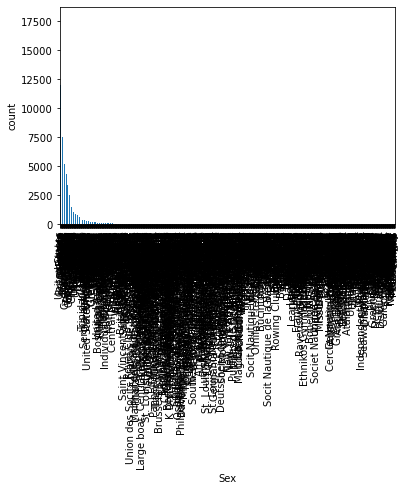

In [219]:
pd.value_counts(df_total_wins['Team']).plot.bar()
plt.ylabel('count')
plt.xlabel('Sex')
plt.show()

In [41]:
olympics_city = df_olympics[['Year', 'City']].drop_duplicates().sort_values('Year')
olympics_city

# Moskva should be Moskow
# Athina should be Athens

,Year,City
3079,1896,Athina
3,1900,Paris
711,1904,St. Louis
268,1906,Athina
1149,1908,London
35,1912,Stockholm
2,1920,Antwerpen
672,1924,Chamonix
39,1924,Paris
133,1928,Amsterdam


# EDA

#### Observations
- summing medal column would be incorrect wins since doesn't account for team wins

In [10]:
print(df_olympics.dtypes)

ID          int64
Name       object
Sex        object
Age       float64
Height    float64
Weight    float64
Team       object
NOC        object
Games      object
Year        int64
Season     object
City       object
Sport      object
Event      object
Medal      object
region     object
notes      object
dtype: object


# Categorical Features
value_counts()

### Sex

In [11]:
print(df_olympics['Sex'].value_counts())

M    196594
F     74522
Name: Sex, dtype: int64


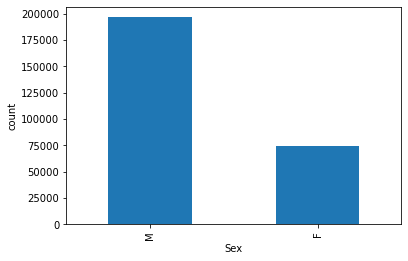

In [12]:
pd.value_counts(df_olympics['Sex']).plot.bar()
plt.ylabel('count')
plt.xlabel('Sex')
plt.show()

### Team

In [13]:
print(df_olympics['Team'].value_counts())

United States     17847
France            11988
Great Britain     11404
Italy             10260
Germany            9326
                  ...  
Kiel                  1
Colette-10            1
Mistral Hojris        1
Solos Carex           1
Camille               1
Name: Team, Length: 1184, dtype: int64


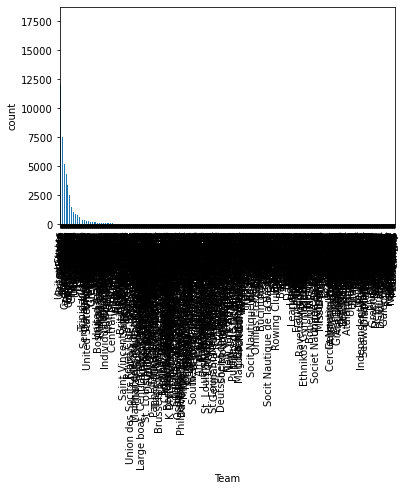

In [14]:
pd.value_counts(df_olympics['Team']).plot.bar()
plt.ylabel('count')
plt.xlabel('Team')
plt.show()

### Year

In [15]:
print(df_olympics['Year'].value_counts())

1992    16413
1988    14676
2000    13821
1996    13780
2016    13688
2008    13602
2004    13443
2012    12920
1972    11959
1984    11588
1976    10502
1968    10479
1964     9480
1952     9358
1960     9235
1980     8937
1948     7480
1936     7401
1956     6434
1924     5693
1928     5574
2014     4891
2010     4402
2006     4382
1920     4292
2002     4109
1912     4040
1998     3605
1932     3321
1994     3160
1908     3101
1900     1936
1906     1733
1904     1301
1896      380
Name: Year, dtype: int64


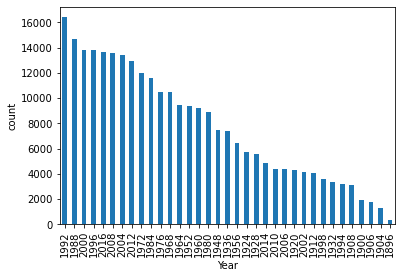

In [16]:
pd.value_counts(df_olympics['Year']).plot.bar()
plt.ylabel('count')
plt.xlabel('Year')
plt.show()

### Season

In [17]:
print(df_olympics['Season'].value_counts())

Summer    222552
Winter     48564
Name: Season, dtype: int64


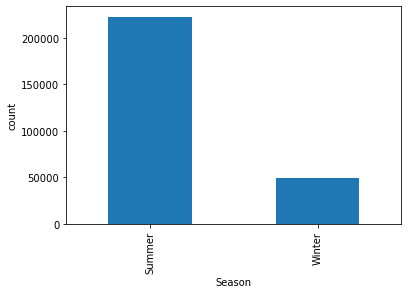

In [18]:
pd.value_counts(df_olympics['Season']).plot.bar()
plt.ylabel('count')
plt.xlabel('Season')
plt.show()

### City

In [19]:
print(df_olympics['City'].value_counts())

London                    22426
Athina                    15556
Sydney                    13821
Atlanta                   13780
Rio de Janeiro            13688
Beijing                   13602
Barcelona                 12977
Los Angeles               12423
Seoul                     12037
Munich                    10304
Montreal                   8641
Mexico City                8588
Helsinki                   8270
Roma                       8119
Tokyo                      7702
Moskva                     7191
Paris                      7169
Berlin                     6506
Amsterdam                  4992
Sochi                      4891
Melbourne                  4829
Vancouver                  4402
Torino                     4382
Stockholm                  4338
Antwerpen                  4292
Salt Lake City             4109
Innsbruck                  3639
Nagano                     3605
Albertville                3436
Lillehammer                3160
Calgary                    2639
Sarajevo

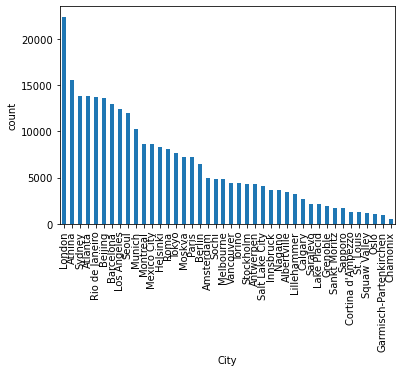

In [20]:
pd.value_counts(df_olympics['City']).plot.bar()
plt.ylabel('count')
plt.xlabel('City')
plt.show()

### Sport

In [21]:
print(df_olympics['Sport'].value_counts())

Athletics        38624
Gymnastics       26707
Swimming         23195
Shooting         11448
Cycling          10859
                 ...  
Racquets            12
Jeu De Paume        11
Roque                4
Basque Pelota        2
Aeronautics          1
Name: Sport, Length: 66, dtype: int64


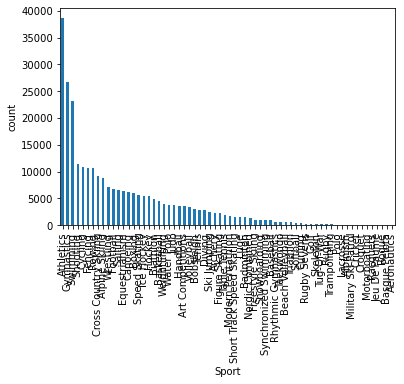

In [22]:
pd.value_counts(df_olympics['Sport']).plot.bar()
plt.ylabel('count')
plt.xlabel('Sport')
plt.show()

### Medal

In [23]:
print(df_olympics['Medal'].value_counts())

DNW       231333
Gold       13372
Bronze     13295
Silver     13116
Name: Medal, dtype: int64


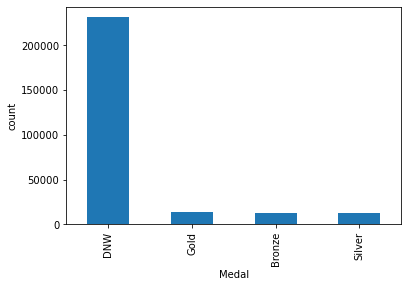

In [24]:
pd.value_counts(df_olympics['Medal']).plot.bar()
plt.ylabel('count')
plt.xlabel('Medal')
plt.show()

### Event

In [25]:
print(df_olympics['Event'].value_counts())

Football Men's Football                                5733
Ice Hockey Men's Ice Hockey                            4762
Hockey Men's Hockey                                    3958
Water Polo Men's Water Polo                            3358
Basketball Men's Basketball                            3280
                                                       ... 
Archery Men's Target Archery, 50 metres, Individual       2
Croquet Mixed Doubles                                     2
Archery Men's Championnat Du Monde                        2
Basque Pelota Men's Two-Man Teams With Cesta              2
Aeronautics Mixed Aeronautics                             1
Name: Event, Length: 765, dtype: int64


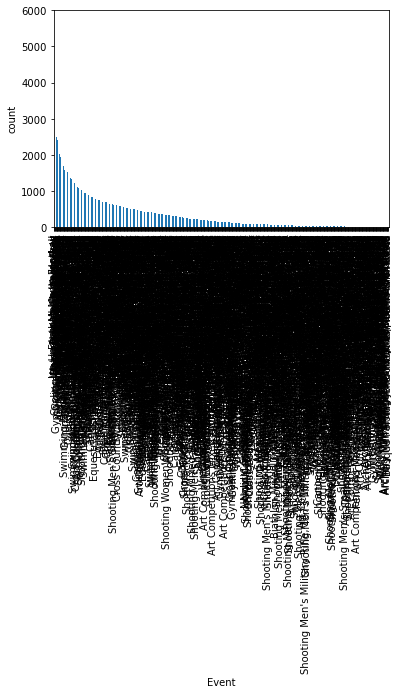

In [26]:
pd.value_counts(df_olympics['Event']).plot.bar()
plt.ylabel('count')
plt.xlabel('Event')
plt.show()

# Continuous Features

.describe()

### Age

In [27]:
print(df_olympics['Age'].describe())

count    261642.000000
mean         25.556898
std           6.393561
min          10.000000
25%          21.000000
50%          24.000000
75%          28.000000
max          97.000000
Name: Age, dtype: float64


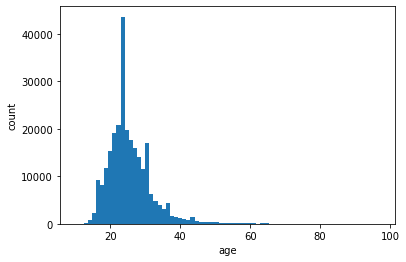

In [28]:
df_olympics['Age'].plot.hist(bins = df_olympics['Age'].nunique())
plt.xlabel('age')
plt.ylabel('count')
plt.show()

### Height

In [29]:
print(df_olympics['Height'].describe())

count    210945.000000
mean        175.338970
std          10.518462
min         127.000000
25%         168.000000
50%         175.000000
75%         183.000000
max         226.000000
Name: Height, dtype: float64


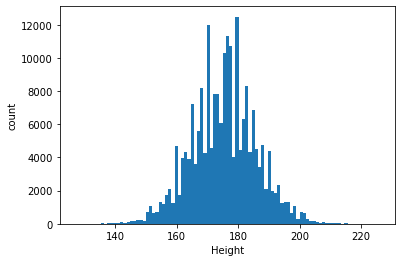

In [30]:
df_olympics['Height'].plot.hist(bins = df_olympics['Height'].nunique())
plt.xlabel('Height')
plt.ylabel('count')
plt.show()

### Weight

In [31]:
print(df_olympics['Weight'].describe())

count    208241.000000
mean         70.702393
std          14.348020
min          25.000000
25%          60.000000
50%          70.000000
75%          79.000000
max         214.000000
Name: Weight, dtype: float64


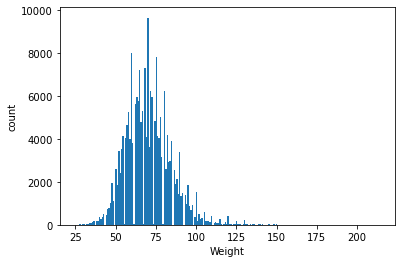

In [32]:
df_olympics['Weight'].plot.hist(bins = df_olympics['Weight'].nunique())
plt.xlabel('Weight')
plt.ylabel('count')
plt.show()

In [ ]:
NAME???

# Visualizations

In [ ]:
# Scatter: Continuous vs. Continuous
df.plot.scatter('age','hours-per-week',s=10,alpha=0.1) # alpha=0.1,s=10
plt.show()

# Heatmap: Continuous vs. Continuous
nbins = 20
heatmap, xedges, yedges = np.histogram2d(df['age'], df['hours-per-week'], bins=nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log10(heatmap).T, origin='lower') # use log count
plt.xlabel('age')
plt.ylabel('hours-per-week')
plt.xticks(np.arange(nbins)[::int(nbins/4)],xedges[::int(nbins/4)].astype(int))
plt.yticks(np.arange(nbins)[::int(nbins/4)],yedges[::int(nbins/4)].astype(int))
plt.colorbar(label='log10(count)')
plt.show()

# Stacked Bar: Categorical vs Categorical
count_matrix = df.groupby(['race', 'gross-income']).size().unstack()
#print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc=4)
plt.show()

# Category specific histograms: continuous vs. categorical 
categories = df['gross-income'].unique()
bin_range = (df['age'].min(),df['age'].max())
for c in categories:
    plt.hist(df[df['gross-income']==c]['age'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('counts')
plt.xlabel('age')
plt.show()

# Box plot: continuous vs. categorical
df[['age','gross-income']].boxplot(by='gross-income')
plt.ylabel('age')
plt.show()

# Violin plot: continuous vs. categorical 
dataset = [df[df['gross-income']==' <=50K']['age'].values,
           df[df['gross-income']==' >50K']['age'].values]

plt.violinplot(dataset = dataset)
plt.xticks([1,2],['<=50k','>50k'])
plt.ylabel('age')
plt.show()

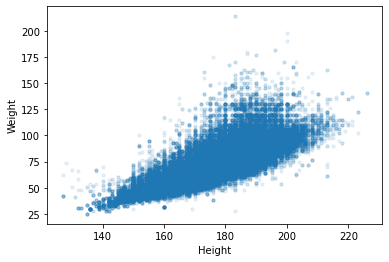

In [33]:
# Scatter: Continuous vs. Continuous
df_olympics.plot.scatter('Height','Weight',s=10,alpha=0.1) # alpha=0.1,s=10
plt.show()

/Users/jilliangreen/anaconda3/envs/data1030/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jilliangreen/anaconda3/envs/data1030/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


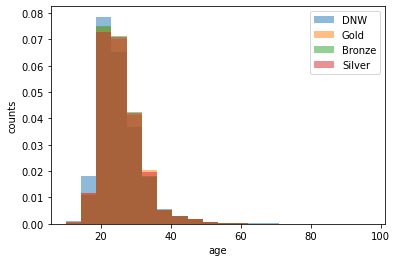

In [34]:
# Category specific histograms: continuous vs. categorical 
categories = df_olympics['Medal'].unique()
bin_range = (df_olympics['Age'].min(),df_olympics['Age'].max())
for c in categories:
    plt.hist(df_olympics[df_olympics['Medal']==c]['Age'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('counts')
plt.xlabel('age')
plt.show()


/Users/jilliangreen/anaconda3/envs/data1030/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


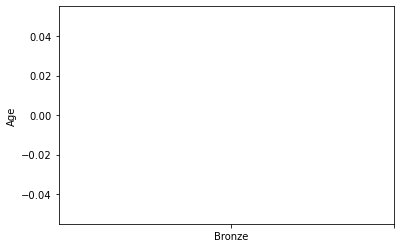

In [35]:
# Violin plot: continuous vs. categorical 
dataset = [df_olympics[df_olympics['Medal']=='Bronze']['Age'].values]

plt.violinplot(dataset = dataset)
plt.xticks([1,2],['Bronze'])
plt.ylabel('Age')
plt.show()



Team    30. Februar  A North American Team  Acipactli   Acturus  Afghanistan  \
Season                                                                         
Summer     0.000009               0.000018   0.000013  0.000009     0.000566   
Winter          NaN                    NaN        NaN       NaN          NaN   

Team    Akatonbo  Alain IV   Albania    Alcaid  Alcyon-6  ...  Ylliam VII  \
Season                                                    ...               
Summer  0.000013  0.000013  0.000283  0.000013  0.000004  ...    0.000027   
Winter       NaN       NaN  0.000144       NaN       NaN  ...         NaN   

Team    Ylliam VIII  Yugoslavia  Yugoslavia-1  Yugoslavia-2    Zambia  \
Season                                                                  
Summer     0.000022    0.009153      0.000009      0.000009  0.000822   
Winter          NaN    0.010728      0.000165      0.000165       NaN   

Team     Zefyros  Zimbabwe       Zut      rn-2  
Season                      

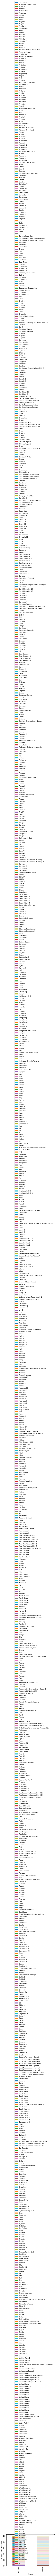

In [36]:
# Stacked Bar: Categorical vs Categorical
count_matrix = df_olympics.groupby(['Season', 'Team']).size().unstack()
#print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc=4)
plt.show()

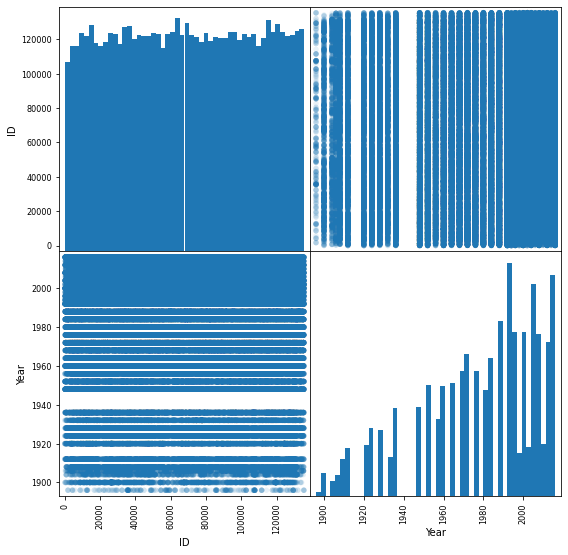

In [37]:
pd.plotting.scatter_matrix(df_olympics.select_dtypes(int), figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, 
                           s=30, alpha=.1)
plt.show()

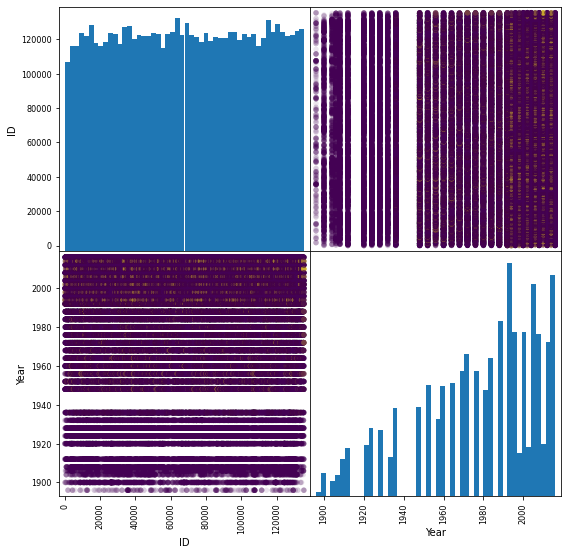

In [85]:
pd.plotting.scatter_matrix(df_athlete_events.select_dtypes(int), figsize=(9, 9),c = pd.get_dummies(df_athlete_events['Sport']).iloc[:,1], 
                           marker='o',hist_kwds={'bins': 50}, s=30, alpha=.1)
plt.show()

In [ ]:
c_medal=olp_data[olp_data['Season']=='Summer'].groupby(['region','Medal'])['Sex'].count().reset_index()
c_medal=c_medal.pivot('region','Medal','Sex').fillna(0).sort_values(by='Gold',ascending=False).head(20)
c_medal.plot(kind='bar')
plt.xlabel('Country')
plt.title('Medals by Country- Summer Olympics ')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

# Prep & Split

This is IID data: all samples stem from the same generative process and the generative process is assumed to have no memory of past generated samples

In [329]:
print(df_olympics.columns)
df_olympics.head(5)
print(df_olympics.dtypes)

Index(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'region', 'notes',
       'Team_Event', 'Single_Event', 'Medal_Won_y', 'Event_Category_y',
       'Medal_Won_Corrected'],
      dtype='object')
ID                       int64
Name                    object
Sex                     object
Age                    float64
Height                 float64
Weight                 float64
Team                    object
NOC                     object
Games                   object
Year                     int64
Season                  object
City                    object
Sport                   object
Event                   object
Medal                   object
region                  object
notes                   object
Team_Event               int64
Single_Event             int64
Medal_Won_y              int64
Event_Category_y         int64
Medal_Won_Corrected    float64
dtype: object


Split by: 60% train, 20% validation, 20% test for small datasets

In [ ]:
# from sklearn.model_selection import train_test_split 
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# # Make code reproducable by setting seed
# np.random.seed(18)

# random_states = [3,18,27,1963,120,114,302,407,423,1201]
    
# # let's separate the feature matrix X, and target variable y
# y = data['Y']                        # target column is Y
# X = data.loc[:, data.columns != 'Y'] # all other columns are features

# for random_state in random_states:

#     print("\n\nFor random state: " + str(random_state))
    
#     # first split to separate out the training set
#     X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)
#     print('training set:',X_train.shape, y_train.shape) # 60% of points are in train

#     # second split to separate out the validation and test sets
#     X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)
#     print('validation set:',X_val.shape, y_val.shape) # 20% of points are in validation
#     print('test set:',X_test.shape, y_test.shape) # 20% of points are in test
#     print("\n")
    
#     # Preprocessor
    
#     # Collect which encoder to use on each feature
#     onehot_ftrs = ['SEX'] # ordinal features w/ no rank
#     minmax_ftrs = ['AGE'] # continuous feature w/ clear boundary 
#     std_ftrs = ['BMI','BP','S1','S2','S3','S4','S5','S6'] # continuous feature w/out clear boundary 

#     # collect all the encoders
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
#             ('minmax', MinMaxScaler(), minmax_ftrs),
#             ('std', StandardScaler(), std_ftrs)])

#     clf = Pipeline(steps=[('preprocessor', preprocessor)]) 

#     X_train_prep = clf.fit_transform(X_train)
#     X_val_prep = clf.transform(X_val)
#     X_test_prep = clf.transform(X_test)

#     print("\n\nTrain Prep Sample: ", X_train_prep[5])
#     print("\n\nVal Prep Sample: ", X_val_prep[5])
#     print("\n\nTest Prep Sample: ", X_test_prep[5])
        

# # Note, we don't need to preprocess the target variable, becuase it already is done (Discussed this in office hours)

In [331]:
df_olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Sport,Event,Medal,region,notes,Team_Event,Single_Event,Medal_Won_y,Event_Category_y,Medal_Won_Corrected
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,Basketball,Basketball Men's Basketball,DNW,China,NaN,0,0,0,0,0.0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,Judo,Judo Men's Extra-Lightweight,DNW,China,NaN,0,0,0,0,0.0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,Football,Football Men's Football,DNW,Denmark,NaN,0,0,0,0,0.0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN,1,0,6,6,1.0
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,NaN,0,0,0,0,0.0


In [16]:
df_olympics.isna().any()

ID                     False
Name                   False
Sex                    False
Age                     True
Height                  True
Weight                  True
Team                   False
NOC                    False
Games                  False
Year                   False
Season                 False
City                   False
Sport                  False
Event                  False
Medal                  False
Country                 True
Country Code            True
Value                   True
Population             False
Team_Event             False
Single_Event           False
Medal_Won_y            False
Event_Category_y       False
Medal_Won_Corrected    False
dtype: bool

In [ ]:

df_olympics_process = df_olympics

from sklearn.model_selection import GroupShuffleSplit
    
# Make code reproducable by setting seed
np.random.seed(18)

# Create list of random states to loop through
random_states = [3] #,18,27,1963,120,114,302,407,423,1201]
    
y = df_olympics_process['Medal_Won_Corrected']                # target column
X = df_olympics_process.drop(["Medal_Won_Corrected"], axis=1) # all other columns are features
groups = df_olympics_process['NOC']                           # group by Name of Country
    
for random_state in random_states:

    print("\n\nFor random state: " + str(random_state))
    
    # Split dataset into train and other
    gss = GroupShuffleSplit(n_splits=10, train_size=.6, random_state=random_state)
    for train_idx, other_idx in gss.split(X, y, groups):
        X_train = X.iloc[train_idx]
        X_other = X.iloc[other_idx]
        y_train = y.iloc[train_idx]
        y_other = y.iloc[other_idx]
        
        #print("\nTraining set: ", X_train.shape, y_train.shape)
    
        # Split Other into Val and Test
        gss2 = GroupShuffleSplit(n_splits=1, train_size=.5, random_state=random_state)
        groups_other = X_other[["NOC"]]
        for val_idx, test_idx in gss2.split(X_other, y_other, groups_other):
            X_val = X_other.iloc[val_idx]
            X_test = X_other.iloc[test_idx]
            y_val = y_other.iloc[val_idx]
            y_test = y_other.iloc[test_idx]

        print("\Train set: ", X_train.shape, y_train.shape)
        print("\Test set: ", X_test.shape, y_test.shape)
        print("\Val set: ", X_val.shape, y_val.shape)

        # Preprocess
        print('here1')
        # Collect which encoder to use on each feature
        ordinal_ftrs = ['Medal'] 
        ordinal_cats = [['DNW','Bronze','Silver','Gold']]
        onehot_ftrs = ['Sex', 'Name','Team','Games','Season','City','Sport','Event','Team_Event','Single_Event'] # ordinal features w/ no rank
        minmax_ftrs = ['Age','Year'] # continuous feature w/ clear boundary 
        std_ftrs = ['Height','Weight','Medal_Won_y','Population'] # continuous feature w/out clear boundary 


        print('here2')
        # collect all the encoders
        preprocessor = ColumnTransformer(
            transformers=[
                ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
                ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                ('minmax', MinMaxScaler(), minmax_ftrs),
                ('std', StandardScaler(), std_ftrs)])
        print('here3')
        clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                               # later on we will add other steps here
        print('here4')
        X_train_prep = clf.fit_transform(X_train)
        print('here5')
        X_val_prep = clf.transform(X_val)
        print('here6')
        X_test_prep = clf.transform(X_test)

        print(X_train.shape)
        print(X_train_prep.shape)
        print(X_train_prep)

        y_train_prep = le.fit_transform(y_train)
        y_val_prep = le.transform(y_val)
        y_test_prep = le.transform(y_test)
        
        print("\n\nTrain Scaled Sample: ", y_train_prep)
        print("\n\nVal Scaled Sample: ", y_val_prep)
        print("\n\nTest Scaled Sample: ", y_test_prep)






For random state: 3
\Train set:  (173803, 23) (173803,)
\Test set:  (75340, 23) (75340,)
\Val set:  (21973, 23) (21973,)
here1
here2
here3
here4


In [38]:
# let's separate the feature matrix X, and target variable y
y = df_olympics['Medal'] # remember, we want to predict who earns more than 50k or less than 50k
X = df_olympics.loc[:, df_olympics.columns != 'Medal'] # all other columns are features
print(y)
print(X.head())


0          DNW
1          DNW
2          DNW
3         Gold
4          DNW
          ... 
271111     DNW
271112     DNW
271113     DNW
271114     DNW
271115     DNW
Name: Medal, Length: 271116, dtype: object
   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 W

In [ ]:
# is the data imbalanced ??? 

NOTES ABOUT DATASET 

Each row corresponds to an individuals appearnace in an Olympic event.

Introduction (5 points)
- Clearly describe the problem you want to solve. 
    - Problem: Predict the number of Medals a country will win
- What is the target variable?
    - Medals Won
- Is the problem regression or classification?
    - Regression, we are trying to predict the number of medals a country will win
- Why is this interesting/important?
    - Winning olympic medals creates job opportunities, increases investments (sponsorships, tourism, revenue), national pride among a country
- Number of data points and number of features.
    - 271116 datapoints, ??? features 
- If dataset is not well-documented, write a description for each feature (if feature is categorical, describe each category; if feature is numerical, include the unit of the quantity and what it measures)
    - ???
- If the dataset is from Kaggle/UCI/already described, write a short description about 2-3 public projects or publications where the data has been used, what did the authors find, what ML question did they solve and how successful they were.
    - ???


In [40]:
print("Number of datapoints: ", len(df_olympics))

Number of datapoints:  271116


Exploratory Data Analysis (15 points)
- Perform a thorough EDA on each column in your dataset and pay special attention to your target variable
    - see above
- Use .describe or .value_counts, create histograms or bar plots as appropriate
    - see above
- Create other type of figures using two columns
    - see above
- Create a scatter matrix
- There is no need to include everything in the report.
- Choose at least three but maximum five figures that you think are interesting or important and one of those figures should show the target variable. Do not include three figures of the same type (e.g., you’ll lose points if you submit three bar plots). Use at least two figure types.
- Write a figure caption for each figure.
- Make sure your figures are publication-quality figures. Please print out your report before you submit it and make sure the figures are readable, the font size is similar to the text font size, axes are labelled, the figures have sufficient resolution (usually 300 dpi).


Data preprocessing (10 points)
- Discuss how you split the dataset and why.
- Is your dataset IID?
    - Not IID since we are grouping by Country to predict number of medals won
- Does it have group structure?
    - Yes, group by Country (NOC)
- Is it a time series data?
    - No
- How should you split the dataset given your ML question to best mimic future use when you deploy the model?
    - Split the data 60/20/20 using GroupShuffleSplit
- Apply MinMaxEncoder or StandardScaler on the continuous features
    - see above
- Apply OneHotEncoder or OrdinalEncoder on categorical features
    - see above
- Apply the LabelEncoder on the target variable if necessary.
    - not necessary since it is a regression target variable
- Describe why you chose the preprocessor you used for each feature.
    - The preprocessors chosen are based on what each features describes. For example, if it is categorical then it is a OneHotEncoder (no rank) or OrdinalEncoder (rank matters). If it is continuous then it is MinMaxEncoder (clear boundary) or StandardScaler (no clear boundary).
- How many features do you have in the preprocessed data?
    - XXX


References (2 points)
- Cite previous work and add your citations to the ‘References’ section which should be the last section of your report.

https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results


Github repository (3 points)
- Please create a public github repository for your project and include the link in your report.
- For now, there should be three folders in your repository:
- - data: download your dataset into this folder.
- - figures: any figures you make should be saved in this folder in png, jpg, or pdf format. You can and should have more figures in here than what you have in your report.
- - src: your python notebooks should be in this folder. Make sure that your code reads in the data from the data folder and saves the figures directly into the figures folder.